In [9]:
import os
import re
import math
import functools
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.layers import Layer, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers, Model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

%matplotlib inline

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [10]:
AUTO = tf.data.experimental.AUTOTUNE
SKIP_VALIDATION = True
BATCH_SIZE = 16
EPOCHS = 7
IMAGE_NORM_MODE = 0  # 0: 0 ~ 1, 1: -1 ~ 1
IMAGE_MAX_SIZE = 441
EMBEDDING_SIZE = 512

In [11]:
train_tfrec_dir = "E:/open_dataset/landmark_v2/tfrec/train*"
valid_tfrec_dir = "E:/open_dataset/landmark_v2/tfrec/valid*"

TRAINING_FILENAMES = tf.io.gfile.glob(train_tfrec_dir)
VALIDATION_FILENAMES = tf.io.gfile.glob(valid_tfrec_dir)

if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

In [12]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAIN_LABEL = 81313
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = 0 if SKIP_VALIDATION else count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 1580468 training images, 0 validation images


In [13]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [22]:
def _parse_example(example):
    name_to_features = {
        'image/height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'image/width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'image/channels': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'image/format': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/id': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/filename': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/encoded': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/class/label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    
    parsed_example = tf.io.parse_single_example(example, name_to_features)
    
    # Parse to get image.
    image = parsed_example['image/encoded']
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    if IMAGE_NORM_MODE == 0:
        image = tf.math.divide(image, 255.0)
    else:
        image = tf.math.divide(tf.subtract(image, 127.5), 127.5)

    # Resize image.
    image = tf.image.resize_with_pad(image, IMAGE_MAX_SIZE, IMAGE_MAX_SIZE)
    image = tf.reshape(image, [IMAGE_MAX_SIZE, IMAGE_MAX_SIZE, 3]) # explicit size needed for TPU
    
    # Parse to get label.
    label = tf.cast(parsed_example['image/class/label'], tf.int32)
    label = tf.one_hot(label, NUM_TRAIN_LABEL)

    return image, label

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(_parse_example, num_parallel_calls=AUTO)
    return dataset

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return tf.keras.backend.dot(tf.keras.backend.dot(rotation_matrix, shear_matrix), tf.keras.backend.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.keras.backend.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = tf.keras.backend.cast(idx2,dtype='int32')
    idx2 = tf.keras.backend.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_MAX_SIZE
    XDIM = DIM % 2 #fix for size 331

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_hue(image, 0.2)
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.keras.backend.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = tf.keras.backend.cast(idx2,dtype='int32')
    idx2 = tf.keras.backend.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

def get_dataset(file_name, augmentation=True, validation=False):
    dataset = load_dataset(file_name)
    
    if augmentation: 
        dataset = dataset.map(transform, num_parallel_calls=AUTO)
    
    if validation:
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    else:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(2048)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

Training data shapes:
(16, 441, 441, 3) (16, 81313)
(16, 441, 441, 3) (16, 81313)
(16, 441, 441, 3) (16, 81313)
Training data label examples: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Validation data shapes:
(16, 441, 441, 3) (16, 81313)
(16, 441, 441, 3) (16, 81313)
(16, 441, 441, 3) (16, 81313)
Validation data label examples: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

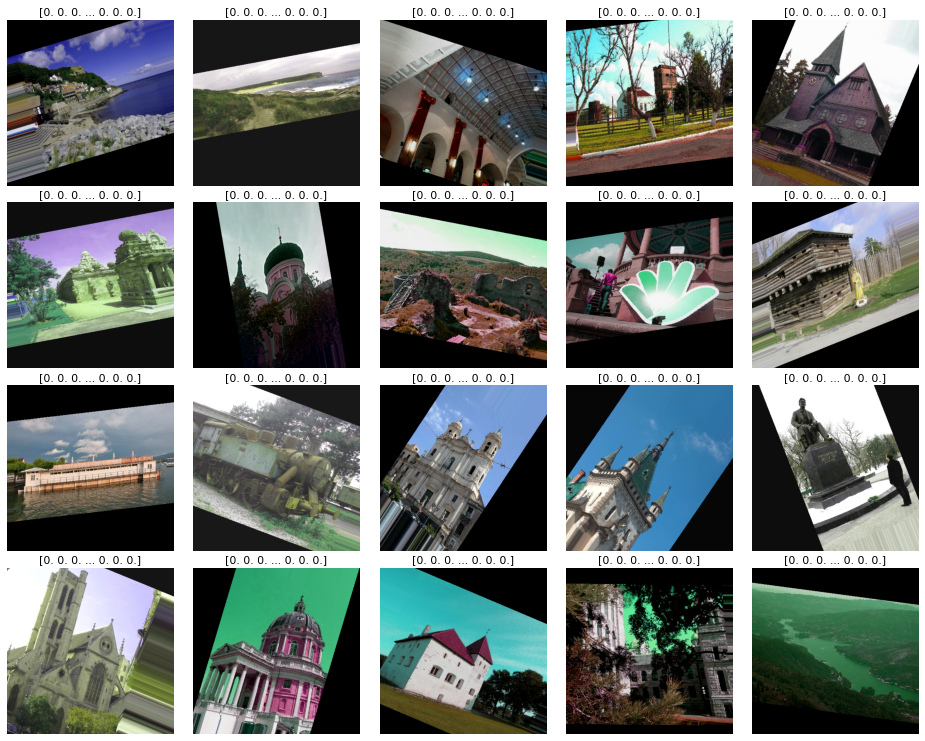

In [23]:

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def display_one_images(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=int(titlesize/1.2), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_images(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

print("Training data shapes:")
for image, label in get_dataset(TRAINING_FILENAMES, validation=False).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_dataset(VALIDATION_FILENAMES, validation=True).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

# Peek at training data
training_dataset = get_dataset(TRAINING_FILENAMES, validation=False)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

# Model setting

## Embedding Model
- EfficientNet B7
- Generalized mean pooling

## Loss Model
- Adacos

In [ ]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [98]:
import efficientnet.tfkeras as efn

from tensorflow.keras.layers import Layer, Dense, BatchNormalization
from tensorflow.keras import regularizers, Model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K
import tensorflow_probability as tfp


class Generalized_mean_pooling2D(Layer):
    def __init__(self, p=3, epsilon=1e-6, **kwargs):
        super(Generalized_mean_pooling2D, self).__init__(**kwargs)

        self.init_p = p
        self.epsilon = epsilon

    def build(self, input_shape):
        if isinstance(input_shape, list) or len(input_shape) != 4:
            raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')

        self.build_shape = input_shape

        self.p = self.add_weight(
              name='p',
              shape=[1,],
              initializer=tf.keras.initializers.Constant(value=self.init_p),
              regularizer=None,
              trainable=True,
              dtype=tf.float32
              )

        self.built=True

    def call(self, inputs):
        input_shape = inputs.get_shape()
        if isinstance(inputs, list) or len(input_shape) != 4:
            raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')

        return (tf.reduce_mean(tf.abs(inputs**self.p), axis=[1,2], keepdims=False) + self.epsilon)**(1.0/self.p)

class AdaCos(Layer):
    def __init__(self, n_classes=10, regularizer=None, **kwargs):
        super(AdaCos, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(AdaCos, self).build(input_shape)
        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)
        
        self.s = tf.Variable(tf.math.sqrt(2.0)*tf.math.log(self.n_classes - 1.0), trainable=False, )
        
    def call(self, inputs):
        # normalize feature
        x = tf.nn.l2_normalize(inputs, axis=1, name='norm_embeddings')
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0, name='norm_loss_weights')
        # dot product
        logits = x @ W
        
        return logits
    
    def get_logits(self, y_true, y_pred):
        logits = y_pred

        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))

        B_avg = tf.where(y_true < 1, tf.exp(self.s*logits), tf.zeros_like(logits))
        B_avg = tf.reduce_mean(tf.reduce_sum(B_avg, axis=1), name='B_avg')
        theta_class = theta[y_true == 1]
        theta_med = tfp.stats.percentile(theta_class, q=50)

        denominator = tf.cos(tf.minimum(math.pi / 4.0, theta_med))
        numerator = tf.math.log(B_avg)
        
        self.s.assign(tf.math.divide_no_nan(numerator, denominator))

        logits = self.s * logits

        return logits

    def loss(self, y_true, y_pred):
        logits = self.get_logits(y_true, y_pred)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
        return loss

    def accuracy(self, y_true, y_pred):
        logits = self.get_logits(y_true, y_pred)
        accuracy = tf.keras.metrics.categorical_accuracy(y_true=y_true, y_pred=logits)
        return accuracy
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_classes)


with strategy.scope():
    enet = efn.EfficientNetB0(
        weights='noisy-student',
        include_top=False
    )
    enet.trainable = True

    loss_model = AdaCos(NUM_TRAIN_LABEL)
    
    model = tf.keras.Sequential([
        enet,
        Generalized_mean_pooling2D(name='GeM'),
        Dense(NUM_TRAIN_LABEL, activation='softmax', name='fc'),
        BatchNormalization(name='batchnorm'),
        loss_model
    ])
    
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss = loss_model.loss,  
              metrics=[loss_model.accuracy])

model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, None, None, 1280)  4049564   
_________________________________________________________________
GeM (Generalized_mean_poolin (None, 1280)              1         
_________________________________________________________________
fc (Dense)                   (None, 2916)              3735396   
_________________________________________________________________
batchnorm (BatchNormalizatio (None, 2916)              11664     
_________________________________________________________________
ada_cos_36 (AdaCos)          (None, 2916)              8503057   
Total params: 16,299,682
Trainable params: 16,251,834
Non-trainable params: 47,848
_________________________________________________________________


In [99]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        
        if not SKIP_VALIDATION:
            model.save_weights('./epoch_{0}_train_acc_{1:.3f}_val_acc_{2:.3f}.h5'.format(epoch, logs['accuracy'], logs['val_accuracy']))
        else:
            model.save_weights('./epoch_{0}_train_acc_{1:.3f}.h5'.format(epoch, logs['accuracy']))
            
history = model.fit(
    get_dataset(TRAINING_FILENAMES), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback, ModelSaveCallback()],
    validation_data=None if SKIP_VALIDATION else get_dataset(VALIDATION_FILENAMES, validation=True)
)



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
26/57 [============>.................] - ETA: 3s - loss: nan - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [97]:
logits = tf.constant([[0.3, 0.31, 0.32, 0.33], [0.2, 0.21, 0.22, 0.23], [0.8, 0.81, 0.82, 0.83]])
print('logits', logits)
y_true = tf.constant([[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=tf.float32)
print('y_true', y_true)

s = tf.Variable(tf.math.sqrt(2.0)*tf.math.log(4 - 1.0))
print('s', s)

theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
print('theta', theta)

pi = tf.Variable(math.pi / 4.0)
print('pi', pi)

B_avg = tf.where(y_true < 1, tf.exp(s*logits), tf.zeros_like(logits))
print('B_avg', B_avg)
B_avg = tf.reduce_mean(tf.reduce_sum(B_avg, axis=1), name='B_avg')
print('B_avg', B_avg)
theta_class = theta[y_true == 1]
print('theta_class', theta_class)
theta_med = tfp.stats.percentile(theta_class, q=50, axis=0)
print('theta_med', theta_med)

denominator = tf.cos(tf.minimum(pi * tf.ones([1, 1]), theta_med * tf.ones([1, 1])))
print('denominator', denominator)
numerator = tf.math.log(B_avg) * tf.ones([1, 1])
print('numerator', numerator)

s = tf.divide(numerator, denominator)
print('s', s)

print(s * logits)

logits tf.Tensor(
[[0.3  0.31 0.32 0.33]
 [0.2  0.21 0.22 0.23]
 [0.8  0.81 0.82 0.83]], shape=(3, 4), dtype=float32)
y_true tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]], shape=(3, 4), dtype=float32)
s <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5536724>
theta tf.Tensor(
[[1.2661037  1.2556033  1.2450669  1.2344928 ]
 [1.3694384  1.3592215  1.3489819  1.3387187 ]
 [0.6435011  0.62664413 0.6093853  0.59168863]], shape=(3, 4), dtype=float32)
pi <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7853982>
B_avg tf.Tensor(
[[1.5937692 0.        1.6440704 1.6698135]
 [1.3644269 1.3857912 0.        1.4295285]
 [3.4657807 3.5200481 3.5751653 0.       ]], shape=(3, 4), dtype=float32)
B_avg tf.Tensor(6.5494647, shape=(), dtype=float32)
theta_class tf.Tensor([1.2556033  1.3489819  0.59168863], shape=(3,), dtype=float32)
theta_med tf.Tensor(1.2556033, shape=(), dtype=float32)
denominator tf.Tensor([[0.70710677]], shape=(1, 1), dtype=float32)
numerator tf.Tensor([[1